In [1]:
from jax import random
import jax
import neural_tangents as nt
from neural_tangents import stax

2023-02-27 14:29:25.739424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def returnsNTkKernel(x_train, kernel_fn, x=None, train=True):
        if train:
            ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
            return ntk_train_train
        ntk_test_train = kernel_fn(x, x_train, 'ntk')
        return ntk_test_train

def EigenDecompositonOfKernel(ntk_train_train):
    eigenvalues, eigenvectors = jax.numpy.linalg.eigh(ntk_train_train)
    return eigenvalues, eigenvectors

def feature(y_train, ntk_test_train, eigenvalues, eigenvectors, i):
    lambda_i, v_i = eigenvalues[i], eigenvectors[i].reshape(eigenvectors[i].shape[0],1)
    output = ntk_test_train @ v_i @ v_i.T @ y_train
    print(output, lambda_i, v_i.T@v_i)
    output = output/lambda_i
    return output

In [7]:
def abstracted(width):
    backbone_init, backbone_fn, backbone_kernel = stax.Dense(width, parameterization = 'ntk')
    init_fn, apply_fn, kernel_fn = stax.serial(
        (backbone_init, backbone_fn, backbone_kernel),
        stax.Dense(1,parameterization = 'ntk'))

    n_train, n_test, d = 1000, 1, 1000 
    key1, key2, key3 = random.split(random.PRNGKey(1), num=3)
    output_shape, params = init_fn(key1, input_shape=(d,))
    delta = jax.numpy.sqrt(d/n_train) + 1
    cov = jax.numpy.identity(d, dtype=None)
    cov = cov.at[0,0].set(1+delta)
    mean = jax.numpy.zeros(d)
    epsilon = 0.1
    x_train = jax.random.multivariate_normal(key2, mean, cov, (n_train,))
    y_train = random.uniform(key2, shape=(n_train, 1))  # training targets
    x_test = jax.random.multivariate_normal(key3, mean, cov, (n_test,))
    
    ntk_matrix_clean = returnsNTkKernel(x_train, kernel_fn, x=None, train=True)
    eigenvalues_clean, eigenvectors_clean = EigenDecompositonOfKernel(ntk_matrix_clean)
    phi_x = backbone_fn(params[0], x_train) # apply the same initialization params to the backbone function also
    phi_x = phi_x/jax.numpy.linalg.norm(phi_x, axis=0)
    norm = eigenvectors_clean.T@phi_x
    return norm, eigenvalues_clean

In [8]:
list_of_widths = [10, 100, 1000, 10000, 100000]
norms = []
eigenvalues = []
for width in list_of_widths:
    norm, eigenvalue = abstracted(width)
    #norm = jax.numpy.mean(norm, axis=1)
    norms.append(norm)
    eigenvalues.append(eigenvalue)

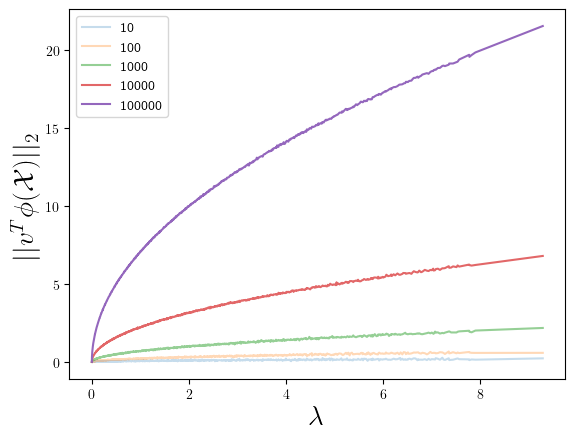

In [16]:
import matplotlib.pyplot as plt
import matplotlib
alpha = [0.25, 0.3, 0.5, 0.7, 1]
plt.rcParams['text.usetex'] = True
for i in range(len(list_of_widths)):
    plt.plot(eigenvalues[i], jax.numpy.linalg.norm(norms[i], ord=2, axis=1), label=list_of_widths[i], alpha=alpha[i])
plt.ylabel(r'$||v^T\phi(\mathcal{X})||_2$',fontsize=20)
plt.xlabel(r'$\lambda$',fontsize=20)
plt.legend()
plt.show()

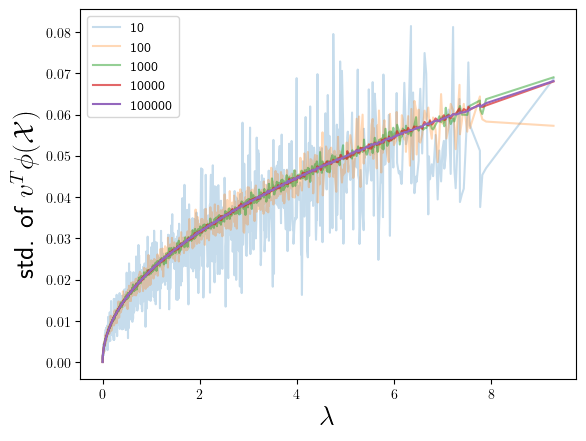

In [13]:
import matplotlib.pyplot as plt
import matplotlib
alpha = [0.25, 0.3, 0.5, 0.7, 1]
plt.rcParams['text.usetex'] = True
for i in range(len(list_of_widths)):
    plt.plot(eigenvalues[i], jax.numpy.std(norms[i],axis=1), label=list_of_widths[i], alpha=alpha[i])
plt.ylabel(r'std. of $v^T\phi(\mathcal{X})$',fontsize=20)
plt.xlabel(r'$\lambda$',fontsize=20)
plt.legend()
plt.show()

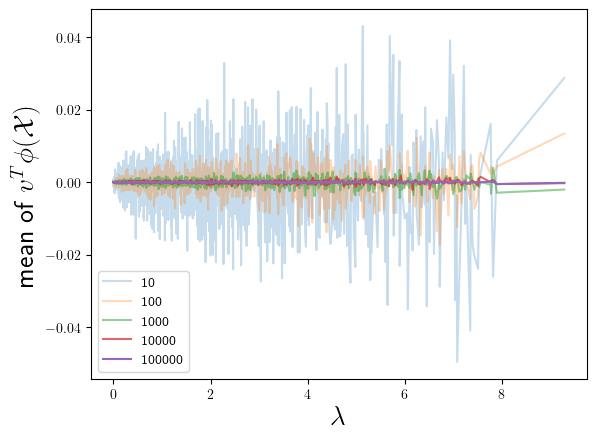

In [10]:
import matplotlib.pyplot as plt
import matplotlib
alpha = [0.25, 0.3, 0.5, 0.7, 1]
for i in range(len(list_of_widths)):
    plt.plot(eigenvalues[i], jax.numpy.mean(norms[i], axis=1), label=list_of_widths[i], alpha=alpha[i])
plt.ylabel(r'mean of $v^T\phi(\mathcal{X})$', fontsize=20)
plt.xlabel(r'$\lambda$',fontsize=20)
plt.legend()
plt.show()